# Class Definitions

In [1]:
import random
import collections
import bisect
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [2]:
#Generate class elevator; It contains the three algorithms we will compare to see which one yields the best results 

class Elevator:
    def __init__(self, capacity):
        self.cap = capacity
        self.floor = 0
        self.targets = []
        
    def maximum(self, pas):
        # initiation
        self.floor = 0
        count = 0
        # sort
        for i in pas:
            pas[i].sort()
        
        while pas:
            
            destination = max(list(pas.keys()), key=lambda x: len(pas[x]))
            count += abs(destination - self.floor)
            self.floor = destination
            
            while pas[destination] and len(self.targets) < self.cap:
                self.targets.append(pas[destination].pop())
                
            if not pas[destination]:
                pas.pop(destination, None)
            
            self.targets.sort(key = lambda x: abs(x - self.floor))
            for i in self.targets:
                count += abs(self.floor - i)
                self.floor = i
            
            self.targets = []
        
        return count
    
    
    def greedy(self, pas):
        
        #initialization
        self.floor = 0
        direction = 1
        count = 0
        
        while pas:
            
            '''
            print("Elevator is at %s floor. Direction: %s" % (self.floor, direction))
            print("Current passengers' destination %s" % self.targets)
            '''
            
            # remove passengers that have reached their target floor
            if self.floor in self.targets:
                self.targets = list(filter(lambda x: x != self.floor, self.targets))
            
            # add passengers on the same direction
            if direction == 1 and pas[self.floor]:
                while len(self.targets) < self.cap and pas[self.floor] and max(pas[self.floor]) > self.floor:
                    ind = pas[self.floor].index(max(pas[self.floor]))
                    self.targets.append(pas[self.floor].pop(ind))
            elif direction == -1 and pas[self.floor]:
                while len(self.targets) < self.cap and pas[self.floor] and min(pas[self.floor]) < self.floor:
                    ind = pas[self.floor].index(min(pas[self.floor]))
                    self.targets.append(pas[self.floor].pop(ind))
            
            #remove floors that have no more passengers
            if not pas[self.floor]:
                pas.pop(self.floor, None)
            
            if len(pas.keys()) > 0 and (self.targets or (direction == 1 and self.floor < max(pas.keys())) or (direction == -1 and self.floor > min(pas.keys()))):
                self.floor += direction
                count += 1
            else:
                direction = -direction
        
        return count
    
    def closest_floor(self, floor, other_floors):
        return sorted(other_floors, key = lambda x: abs(floor - x))[0]
    
    def random(self,pas):
        #initialization
        self.floor = 0
        count = 0
        loaded = 0
        
        #Run loop till no passengers left on all floor
        while len(list(pas.keys())) != 0:
            next_floor = self.closest_floor(self.floor, list(pas.keys()))
            count += abs(self.floor - next_floor)

            while loaded < self.cap and len(pas.get(next_floor)) != 0:
                loaded += 1                                            
                self.targets.append(pas.get(next_floor).pop(0))
                
            #Check if floor is empty, if it is then delete it
            if len(pas.get(next_floor)) == 0:
                del pas[next_floor]

            #choose random floor to go to   
            random_floor = random.choice(self.targets)
            count += abs(next_floor - random_floor)
            self.floor = random_floor
            for i in self.targets:
                if i == random_floor:
                    self.targets.remove(i)
                    loaded -= 1

        return count

In [3]:
#Generate class building; It generates all the passengers, their initial position and their desired goal.

class Building:
    def __init__(self, floor, passengers):
        self.floor = floor
        self.passengers = collections.defaultdict(list)
        self.generatePassenger(passengers)
    
    def generatePassenger(self, num):
        for _ in range(num):
            f = random.randint(0, self.floor - 1)
            self.passengers[f].append(self.generateDes(f))
    
    #generate destination
    def generateDes(self, start):
        temp = start
        while temp == start:
            temp = random.randint(0, self.floor - 1)
        d = 1 if temp > start else -1
        return temp
    
    #generate biased destination. This is to model more realistic scenarios where people
    #are more likely to go to floors closer to the ground floor/lobby
    def generateBiasedDes(self, start):
        if start != 0 and random.random() < 0.5:
            return 0
        else:
            temp = start
            while temp == start:
                temp = random.randint(0, self.floor - 1)
            return temp
    
    def generateBiasedPassenger(self, num):
        for _ in range(num):
            if random.random() < 0.5:
                self.passengers[0].append(self.generateDes(0))
            else:
                f = random.randint(0, self.floor - 1)
                self.passengers[f].append(self.generateBiasedDes(f))

# Testing

In [4]:
max_s = []
greedy_s = []
random_s = []

#Generate passengers and send them to their destination using multiple algorithms
for _ in range(1000):
    test = Building(20, 50).passengers
    ele = Elevator(2)
    max_s.append(ele.maximum(copy.deepcopy(test)))
    random_s.append(ele.random(copy.deepcopy(test)))
    greedy_s.append(ele.greedy(test))

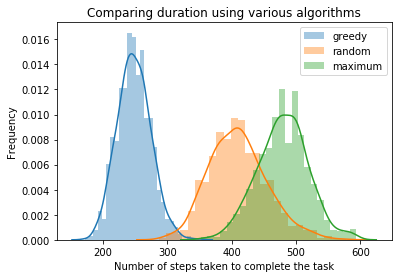

In [5]:
#Graph comparing the three algorithms
sns.distplot(greedy_s, label = "greedy")
sns.distplot(random_s, label = "random")
sns.distplot(max_s, label = "maximum")
plt.title('Comparing duration using various algorithms')
plt.xlabel('Number of steps taken to complete the task')
plt.ylabel('Frequency')
plt.legend()

In [6]:
elevator_x = range(1, 10)
elevator_y = []

for cap in elevator_x:
    res = 0
    for _ in range(1000):
        test = Building(20, 50).passengers
        ele = Elevator(cap)
        res += ele.greedy(test)
    elevator_y.append(res / 1000)

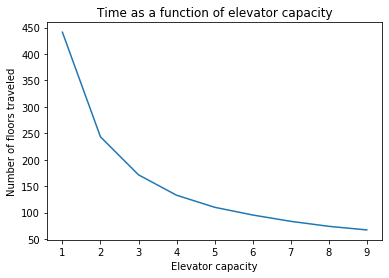

In [7]:
#Graph showing the importance of a good elevator capacity
plt.plot(elevator_x, elevator_y)
plt.title('Time as a function of elevator capacity')
plt.xlabel("Elevator capacity")
plt.ylabel("Number of floors traveled")
plt.show()

# Extending to Multiple Elevators

In [8]:
class MElevator:
    def __init__(self, capacity):
        self.cap = capacity
        self.floor = 0
        self.direction = 1
        self.targets = []
        
    def load(self, tasks):
        if not tasks: return
#         print("Elevator at %s floor. Targets: %s" % (self.floor, self.targets))
        self.targets = [i for i in self.targets if i != self.floor]
        
        if self.direction == 1:
            while len(self.targets) < self.cap and tasks[self.floor] and max(tasks[self.floor]) > self.floor:
                self.targets.append(tasks[self.floor].pop(tasks[self.floor].index(max(tasks[self.floor]))))
        else:
            while len(self.targets) < self.cap and tasks[self.floor] and min(tasks[self.floor]) < self.floor:
                self.targets.append(tasks[self.floor].pop(tasks[self.floor].index(min(tasks[self.floor]))))
        
        if not tasks[self.floor]:
            tasks.pop(self.floor, None)
            
        if not tasks: return
        
        if self.targets or (self.direction == 1 and max(tasks) > self.floor) or (self.direction == -1 and min(tasks) < self.floor):
            self.floor += self.direction
        else:
            self.direction = -self.direction

In [9]:
test = Building(20, 50).passengers
ele = [MElevator(2) for _ in range(2)]
count = 0

while test:
    for i in ele:
        i.load(test)
    count += 1

count

103

In [10]:
class SpecElevator:
    def __init__(self, capacity, floor_range):
        self.cap = capacity
        self.floor = floor_range[0]
        self.floor_range = floor_range
        self.direction = 1
        self.targets = []
        
    def load(self, tasks):
        if not tasks: return
        #print("Elevator at %s floor. Targets: %s" % (self.floor, self.targets))
        temp = [i for i in self.targets if i[0] == self.floor]
        self.targets = [i for i in self.targets if i[0] != self.floor]
        
        for m in temp:
            if m[0] != m[1]:
                tasks[m[0]].append(m[1])
                
        if (self.direction == 1 and self.floor == self.floor_range[1]) or (self.direction == -1 and self.floor == self.floor_range[0]):
            self.direction = -self.direction
            return
        
        if self.direction == 1:
            available = [i for i in range(len(tasks[self.floor])) if self.floor < tasks[self.floor][i]]
            while available and len(self.targets) < self.cap:
                temp = tasks[self.floor].pop(available.pop())
                if temp <= self.floor_range[1]:
                    self.targets.append((temp, temp))
                else:
                    self.targets.append((self.floor_range[1], temp))
        else:
            available = [i for i in range(len(tasks[self.floor])) if tasks[self.floor][i] < self.floor]
            while available and len(self.targets) < self.cap:
                temp = tasks[self.floor].pop(available.pop())
                if temp >= self.floor_range[0]:
                    self.targets.append((temp, temp))
                else:
                    self.targets.append((self.floor_range[0], temp))
        
        if not tasks[self.floor]:
            tasks.pop(self.floor, None)
            
        if not tasks: return
        
        rest = False
        if not self.targets:
            if self.direction == 1:
                for k in tasks:
                    if self.floor < k < self.floor_range[1]:
                        rest = True
                        break
                    elif k == self.floor_range[1]:
                        for m in tasks[k]:
                            if m < k:
                                rest = True
                                break
            else:
                for k in tasks:
                    if self.floor_range[0] < k < self.floor:
                        rest = True
                        break
                    elif k == self.floor_range[0]:
                        for m in tasks[k]:
                            if m > k:
                                rest = True
                                break   
        
        if self.targets or rest:
            self.floor += self.direction
        else:
            self.direction = -self.direction

In [11]:
test = Building(20, 50).passengers
ele = [SpecElevator(2, (0, 10)), SpecElevator(2, (10, 20))]
count = 0

while test:
    for i in ele:
        i.load(test)
    count += 1

count

149

In [12]:
all_ele = []
divided_ele = []

def allEle(test):
    ele = [MElevator(2) for _ in range(2)]
    count = 0
    
    while test:
        for i in ele:
            i.load(test)
        count += 1
    
    return count

def dividedEle(test):
    ele = [SpecElevator(2, (0, 10)), SpecElevator(2, (10, 20))]
    count = 0
    
    while test:
        for i in ele:
            i.load(test)
        count += 1
    
    return count

for _ in range(1000):
    test = Building(20, 50).passengers
    all_ele.append(allEle(copy.deepcopy(test)))
    divided_ele.append(dividedEle(test))

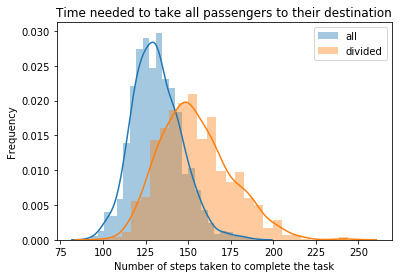

In [13]:
sns.distplot(all_ele, label = "all")
sns.distplot(divided_ele, label = "divided")
plt.title('Time needed to take all passengers to their destination')
plt.xlabel('Number of steps taken to complete the task')
plt.ylabel('Frequency')
plt.legend()

In [14]:
elevator_x = range(1, 10)
elevator_y = []

for num in elevator_x:
    count = 0
    for _ in range(500):
        test = Building(20, 50).passengers
        ele = [MElevator(2) for _ in range(num)]    
        while test:
            for i in ele:
                i.load(test)
            count += 1
    elevator_y.append(count / 1000)

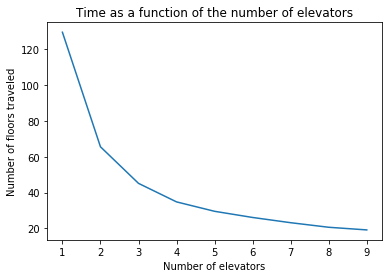

In [21]:
plt.plot(elevator_x, elevator_y)
plt.title('Time as a function of the number of elevators')
plt.xlabel("Number of elevators")
plt.ylabel("Number of floors traveled")
plt.show()

# Shift Distributions

In [16]:
def generateD():
    b = Building(20, 50)
    b.passengers = collections.defaultdict(list)
    b.generateBiasedPassenger(50)
    
    return b.passengers

In [17]:
max_s = []
greedy_s = []
random_s = []

for _ in range(1000):
    test = generateD()
    ele = Elevator(2)
    max_s.append(ele.maximum(copy.deepcopy(test)))
    random_s.append(ele.random(copy.deepcopy(test)))
    greedy_s.append(ele.greedy(test))

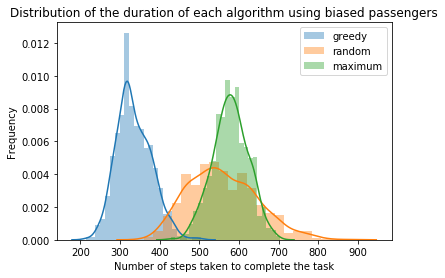

In [27]:
sns.distplot(greedy_s, label = "greedy")
sns.distplot(random_s, label = "random")
sns.distplot(max_s, label = "maximum")
plt.title('Distribution of the duration of each algorithm using biased passengers')
plt.xlabel('Number of steps taken to complete the task')
plt.ylabel('Frequency')
plt.legend()

In [19]:
all_ele = []
divided_ele = []

def allEle(test):
    ele = [MElevator(2) for _ in range(2)]
    count = 0
    
    while test:
        for i in ele:
            i.load(test)
        count += 1
    
    return count

def dividedEle(test):
    ele = [SpecElevator(2, (0, 10)), SpecElevator(2, (10, 20))]
    count = 0
    
    while test:
        for i in ele:
            i.load(test)
        count += 1
    
    return count

for _ in range(1000):
    test = generateD()
    all_ele.append(allEle(copy.deepcopy(test)))
    divided_ele.append(dividedEle(test))

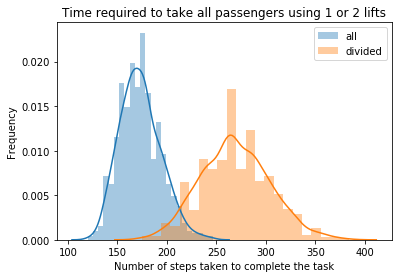

In [29]:
sns.distplot(all_ele, label = "all")
sns.distplot(divided_ele, label = "divided")
plt.title('Time required to take all passengers using 1 or 2 lifts')
plt.xlabel('Number of steps taken to complete the task')
plt.ylabel('Frequency')
plt.legend()